In [1]:
import os
import sys
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
sys.path.append('/home/Public/SiameseEQTransformer/S-EqT_open_source/SiameseEarthquakeTransformer/S_EqT_codes/')
import warnings
warnings.filterwarnings("ignore")
from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False
from keras.models import Model
from keras.layers import Input
import keras.backend as K
import numpy as np
from src.S_EqT_concate_fix_corr import S_EqT_Concate_RSRN_Model, feature_map_corr_func, feature_map_corr_layer, build_corr_model
from src.data_preprocessing import get_siamese_input_list, get_response_list_for_vis
import yaml
from src.data_preprocessing import normalize_by_std
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Using TensorFlow backend.


# Explore hidden responses inside the P branch

### Load EqT and S-EqT models

In [2]:
cfgs = yaml.load(open('/home/Public/SiameseEQTransformer/S-EqT_open_source/SiameseEarthquakeTransformer/S_EqT_codes/configs/P_branch.yaml','r'), Loader=yaml.BaseLoader)
encode_model, siamese_model, EqT_model = S_EqT_Concate_RSRN_Model(cfgs)
siamese_model.load_weights('/home/Public/SiameseEQTransformer/S-EqT_open_source/SiameseEarthquakeTransformer/models/S_EqT/S_EqT_P_branch.hdf5')
SEqT_penultimate = Model(siamese_model.input,siamese_model.get_layer('concatenate_26').output)
model_corr = build_corr_model(cfgs = cfgs, EqT_model = EqT_model)

Start loading EqT model...


Start building EqT encoder model...
Start building Siamese EqT model...
Start building correlation layers...
Start sideoutput & residual layers...
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 6000, 3)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 6000, 8)      272         input[0][0]                      
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 3000, 8)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1

### Load example data

In [3]:
four_examples = np.load('/home/Public/SiameseEQTransformer/S-EqT_open_source/SiameseEarthquakeTransformer/Tutorial/01_explore_hidden_responses_in_the_pretrained_EqT/Four_examples.npy',allow_pickle=True)[()]
template = four_examples['CI.DEC']
search = four_examples['CI.RIN']

### Calculate hidden responses inside the EqT and S-EqT models

In [4]:
# get hidden responses and predictions from the pre-trained EqT model
# template data
data_t = template['data']
data_t = normalize_by_std(data_t)
data_t_in = np.zeros([1,6000,3])
data_t_in[0,:,:] = data_t[:,:]
encoded_t = encode_model.predict(data_t_in)
template_eqt_pred = EqT_model.predict(data_t_in)

# get EqT prediction on the templates
template_eqt_output = EqT_model.predict(data_t_in)
spt_t_eqt = np.argmax(template_eqt_output[1][0,:,0])
sst_t_eqt = np.argmax(template_eqt_output[2][0,:,0])

# search data
data_s = search['data']
data_s = normalize_by_std(data_s)
data_s_in = np.zeros([1,6000,3])
data_s_in[0,:,:] = data_s[:,:]
encoded_s = encode_model.predict(data_s_in)
search_eqt_pred = EqT_model.predict(data_s_in)

# S-EqT predicition on search seismogram
siamese_input_list = get_siamese_input_list(cfgs, spt_t_eqt, sst_t_eqt, encoded_t.copy(), encoded_s.copy())
search_seqt_pred = siamese_model.predict(siamese_input_list)
search_SEqT_penultimate_response = SEqT_penultimate.predict(siamese_input_list)
# get responses for visualization
vis_cfgs = yaml.load(open('/home/Public/SiameseEQTransformer/S-EqT_open_source/SiameseEarthquakeTransformer/S_EqT_codes/configs/Vis_config.yaml','r'), Loader=yaml.BaseLoader)

output_dict = dict()
output_list = []
RSRN_lengths = vis_cfgs['Model']['RSRN_Encoded_lengths']
RSRN_channels = vis_cfgs['Model']['RSRN_Encoded_channels']
encoded_list = vis_cfgs['Model']['RSRN_Encoded_list']
for encoded_name in encoded_list:
    output_dict[encoded_name] =  EqT_model.get_layer(encoded_name).output
    output_list.append(output_dict[encoded_name])
model_encoded_for_vis = Model(inputs = EqT_model.input, outputs = output_list)

encoded_t_plot = model_encoded_for_vis.predict(data_t_in)
encoded_s_plot = model_encoded_for_vis.predict(data_s_in)
encoded_t_slice = encoded_t_plot.copy()

# define inputs
S_EqT_Input_dict = dict()
S_EqT_Input_list = []
encoded_channels = RSRN_channels
encoded_lengths = RSRN_lengths
for idx, encoded_name in enumerate(encoded_list):
    S_EqT_Input_dict[encoded_name+'_Template'] = Input(shape=[None,1,int(encoded_channels[idx])],name=encoded_name+'_Template')
    S_EqT_Input_dict[encoded_name+'_Search'] = Input(shape=[int(encoded_lengths[idx]),1,int(encoded_channels[idx])],name=encoded_name+'_Search')
    S_EqT_Input_list.append(S_EqT_Input_dict[encoded_name+'_Template'])
    S_EqT_Input_list.append(S_EqT_Input_dict[encoded_name+'_Search'])

# define correlation results
concate_with_ori = int(cfgs['Model']['Concate_with_ori'])
feature_corr_dict = dict()
S_EqT_Output_list = []
for idx, encoded_name in enumerate(encoded_list):
    feature_corr_dict[encoded_name+'_corr']  = feature_map_corr_layer(encoded_name+'_corr',(int(encoded_lengths[idx]),1,int(encoded_channels[idx])))([S_EqT_Input_dict[encoded_name+'_Template'],S_EqT_Input_dict[encoded_name+'_Search'] ])
    S_EqT_Output_list.append(feature_corr_dict[encoded_name+'_corr'])
model_corr_for_vis = Model(inputs = S_EqT_Input_list, outputs = S_EqT_Output_list)

# origion responses and their cross-corelations
ori_response_list_for_vis, enhanced_response_list_for_vis = get_response_list_for_vis(vis_cfgs, spt_t_eqt, sst_t_eqt, encoded_t_slice, encoded_s_plot)
ori_corr = model_corr_for_vis.predict(ori_response_list_for_vis)
enhanced_corr =  model_corr_for_vis.predict(enhanced_response_list_for_vis)

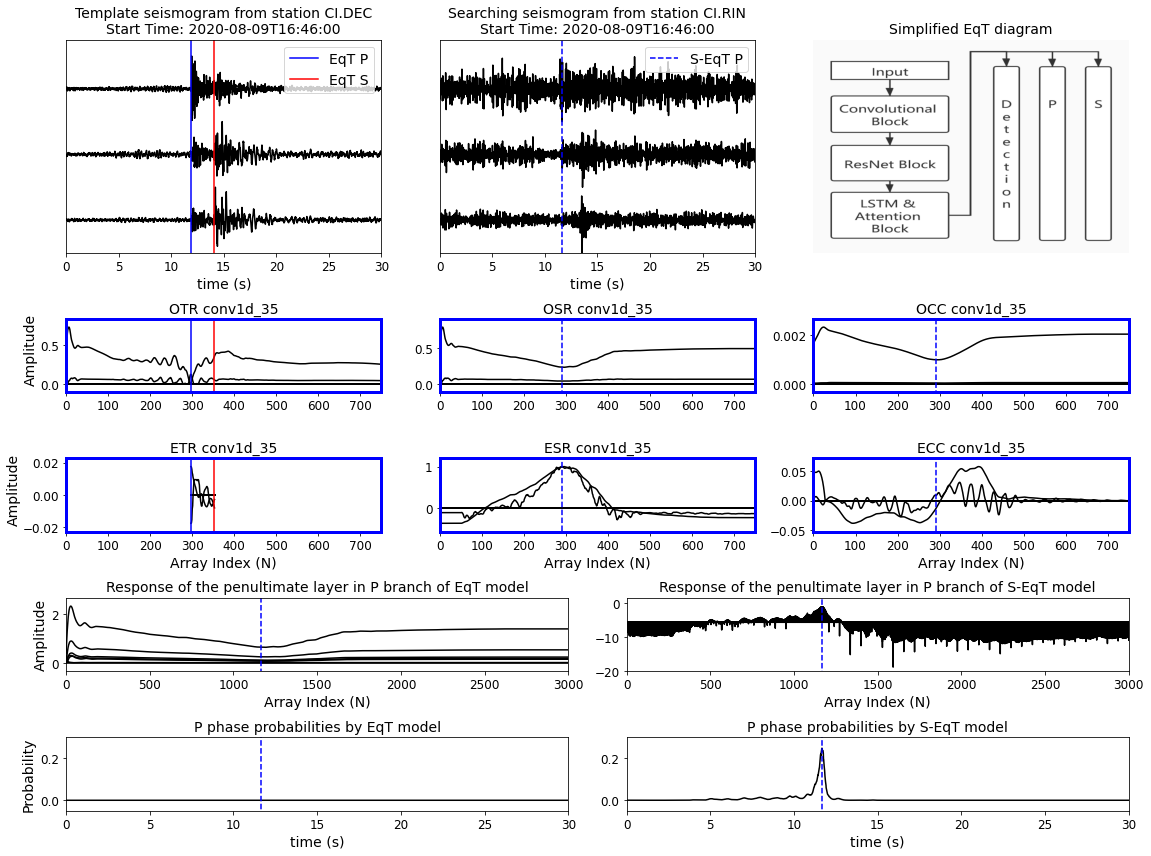

In [5]:
"""
Codes to be cleaned
data_t
data_s
plot_t
start_sample = 0
end_sample = 3001
spt_t_eqt
sst_t_eqt
"""
#encoded_t_plot = encoded_t
encoded_s  = encoded_s_plot
corr_res = enhanced_corr
res_search = search_eqt_pred
pred_res = search_seqt_pred
SEqT_P = np.argmax(search_seqt_pred[-1][0,:,0,0])
plot_t = np.arange(0,30.01,0.01)
plt.figure(figsize=(16,12))
ax1 = plt.subplot2grid((6,6),(0,4),colspan=2,rowspan=2)
plt.title('Simplified EqT diagram',fontsize=14)
img = mpimg.imread('/home/Public/SiameseEQTransformer/S-EqT_open_source/SiameseEarthquakeTransformer/Tutorial/01_explore_hidden_responses_in_the_pretrained_EqT/resources/EqT_diagram.jpg')
plt.imshow(img,aspect='auto')
plt.xticks([])
plt.yticks([])
ax1.axis('off')

ax_t1 = plt.subplot2grid((6,6),(0,0),rowspan=2,colspan=2)
for idx in range(3):
    plt.plot(plot_t,data_t[0:3001,idx]/np.max(np.abs(data_t[0:3001,idx]))+idx*2 + 2,color='k')
    if idx == '0':
        plt.text(28, idx*2 + 2 + 0.1, 'E')
    if idx == '1':
        plt.text(28, idx*2 + 2 + 0.1, 'N')
    if idx == '2':
        plt.text(28, idx*2 + 2 + 0.1, 'Z')

plt.plot([spt_t_eqt/100.0,spt_t_eqt/100.0],[1,8],color='b',label='EqT P')
plt.plot([sst_t_eqt/100.0,sst_t_eqt/100.0],[1,8],color='r',label='EqT S')
plt.title('Template seismogram from station CI.DEC\nStart Time: 2020-08-09T16:46:00',fontsize=14)
plt.ylim([1,7.5])
plt.legend(loc='upper right',prop= {'size':14})
plt.yticks([])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0,30])
plt.xlabel('time (s)',fontsize=14)

ax_t2 = plt.subplot2grid((6,6),(2,0),colspan=2)
rdx = 29
t_len = int(len(encoded_t_plot[rdx][0,:,0])/2.0)
for channel_dx in range(int(RSRN_channels[rdx])):
    plt.plot(encoded_t_plot[rdx][0,:t_len,channel_dx] + 0 * 2,color='k')
plt.xlim([0,t_len])
plt.title('OTR conv1d_35',fontsize=14)
plt.plot([spt_t_eqt/4.0,spt_t_eqt/4.0],[-50,50],color='b',label='EqT P')
plt.plot([sst_t_eqt/4.0,sst_t_eqt/4.0],[-50,50],color='r',label='EqT S')
t_min_plot = np.min(encoded_t_plot[rdx])
t_max_plot = np.max(encoded_t_plot[rdx])
t_gain = (t_max_plot - t_min_plot)*0.15
plt.ylim([t_min_plot - t_gain,t_max_plot + t_gain])
t_ax=plt.gca();t_ax.spines['right'].set_color('b');t_ax.spines['top'].set_color('b');t_ax.spines['bottom'].set_color('b');t_ax.spines['left'].set_color('b');t_ax.spines['right'].set_linewidth(3);t_ax.spines['top'].set_linewidth(3);t_ax.spines['bottom'].set_linewidth(3);t_ax.spines['left'].set_linewidth(3)
plt.text(-100,t_min_plot+t_gain*0.15,'Amplitude',fontsize=14,rotation=90)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax_t3 = plt.subplot2grid((6,6),(3,0),colspan=2)
rdx = 29
t_len = int(len(encoded_t_plot[rdx][0,:,0])/2.0)
start_dx = int(spt_t_eqt*int(RSRN_lengths[rdx])/6000.0)
end_dx = start_dx + len(encoded_t_slice[rdx][0,:,0,0])
temp_x_plot = np.arange(start_dx,end_dx,1)
for channel_dx in range(int(RSRN_channels[rdx])):
    plt.plot(temp_x_plot, encoded_t_slice[rdx][0,:,0,channel_dx] + 0 * 2,color='k')
plt.xlim([0,t_len])
plt.title('ETR conv1d_35',fontsize=14)
plt.plot([spt_t_eqt/4.0,spt_t_eqt/4.0],[-50,50],color='b',label='EqT P')
plt.plot([sst_t_eqt/4.0,sst_t_eqt/4.0],[-50,50],color='r',label='EqT S')
t_min_plot = np.min(encoded_t_slice[rdx])
t_max_plot = np.max(encoded_t_slice[rdx])
t_gain = (t_max_plot - t_min_plot)*0.15
plt.ylim([t_min_plot - t_gain,t_max_plot + t_gain])
t_ax=plt.gca();t_ax.spines['right'].set_color('b');t_ax.spines['top'].set_color('b');t_ax.spines['bottom'].set_color('b');t_ax.spines['left'].set_color('b');t_ax.spines['right'].set_linewidth(3);t_ax.spines['top'].set_linewidth(3);t_ax.spines['bottom'].set_linewidth(3);t_ax.spines['left'].set_linewidth(3)
plt.text(-140,t_min_plot+t_gain*0.15,'Amplitude',fontsize=14,rotation=90)
plt.xlabel('Array Index (N)',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax_t4 = plt.subplot2grid((6,6),(2,4),colspan=2)
rdx = 29
t_len = int(len(encoded_t_plot[rdx][0,:,0])/2.0)
for channel_dx in range(int(RSRN_channels[rdx])):
    plt.plot(ori_corr[rdx][0,:t_len,0,channel_dx]/57.0 + 0 * 2,color='k')
plt.xlim([0,t_len])
plt.title('OCC conv1d_35',fontsize=14)
t_min_plot = np.min(ori_corr[rdx])/57.0
t_max_plot = np.max(ori_corr[rdx])/57.0
t_gain = (t_max_plot - t_min_plot)*0.15
plt.ylim([t_min_plot - t_gain,t_max_plot + t_gain])
plt.plot([SEqT_P/4.0,SEqT_P/4.0],[-50,50],color='b',linestyle='--',label='S-EqT P')
#plt.plot([SEqT_S/4.0,SEqT_S/4.0],[-50,50],color='r',linestyle='--',label='S-EqT S')
t_ax=plt.gca();t_ax.spines['right'].set_color('b');t_ax.spines['top'].set_color('b');t_ax.spines['bottom'].set_color('b');t_ax.spines['left'].set_color('b');t_ax.spines['right'].set_linewidth(3);t_ax.spines['top'].set_linewidth(3);t_ax.spines['bottom'].set_linewidth(3);t_ax.spines['left'].set_linewidth(3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax_s1 = plt.subplot2grid((6,6),(0,2),rowspan=2,colspan=2)
for idx in range(3):
    plt.plot(plot_t,data_s[0:3001,idx]/np.max(np.abs(data_s[0:3001,idx]))+idx*2 + 2,color='k')
    if idx == '0':
        plt.text(28, idx*2 + 2 + 0.1, 'E')
    if idx == '1':
        plt.text(28, idx*2 + 2 + 0.1, 'N')
    if idx == '2':
        plt.text(28, idx*2 + 2 + 0.1, 'Z')

plt.yticks([])
plt.plot([SEqT_P/100.0,SEqT_P/100.0],[1,8],color='b',linestyle='--',label='S-EqT P')
plt.xlim([0,30])
plt.ylim([1,7.5])
plt.legend(loc='upper right',prop= {'size':14})
#plt.text(0,7.5,'(c)',fontsize=20)
plt.title('Searching seismogram from station CI.RIN\nStart Time: 2020-08-09T16:46:00',fontsize=14)
plt.xlabel('time (s)',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax_s2 = plt.subplot2grid((6,6),(2,2),colspan=2)
rdx = 29
t_len = int(len(ori_response_list_for_vis[rdx*2+1][0,:,0,0])/2.0)
for channel_dx in range(int(RSRN_channels[rdx])):
    plt.plot(ori_response_list_for_vis[rdx*2+1][0,:t_len,0,channel_dx] + 0 * 2,color='k')    
plt.xlim([0,t_len])
plt.title('OSR conv1d_35',fontsize=14)
t_min_plot = np.min(ori_response_list_for_vis[rdx*2+1])
t_max_plot = np.max(ori_response_list_for_vis[rdx*2+1])
t_gain = (t_max_plot - t_min_plot)*0.15
plt.ylim([t_min_plot - t_gain,t_max_plot + t_gain])
plt.plot([SEqT_P/4.0,SEqT_P/4.0],[-50,50],color='b',linestyle='--',label='S-EqT P')
#plt.plot([SEqT_S/4.0,SEqT_S/4.0],[-50,50],color='r',linestyle='--',label='S-EqT S')
t_ax=plt.gca();t_ax.spines['right'].set_color('b');t_ax.spines['top'].set_color('b');t_ax.spines['bottom'].set_color('b');t_ax.spines['left'].set_color('b');t_ax.spines['right'].set_linewidth(3);t_ax.spines['top'].set_linewidth(3);t_ax.spines['bottom'].set_linewidth(3);t_ax.spines['left'].set_linewidth(3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax_s3 = plt.subplot2grid((6,6),(3,2),colspan=2)
rdx = 29
t_len = int(len(encoded_s[rdx][0,:,0,0])/2.0)
for channel_dx in range(int(RSRN_channels[rdx])):
    plt.plot(encoded_s[rdx][0,:t_len,0,channel_dx] + 0 * 2,color='k')
plt.xlim([0,t_len])
plt.title('ESR conv1d_35',fontsize=14)
t_min_plot = np.min(encoded_s[rdx])
t_max_plot = np.max(encoded_s[rdx])
t_gain = (t_max_plot - t_min_plot)*0.15
plt.ylim([t_min_plot - t_gain,t_max_plot + t_gain])
plt.plot([SEqT_P/4.0,SEqT_P/4.0],[-50,50],color='b',linestyle='--',label='S-EqT P')
#plt.plot([SEqT_S/4.0,SEqT_S/4.0],[-50,50],color='r',linestyle='--',label='S-EqT S')
t_ax=plt.gca();t_ax.spines['right'].set_color('b');t_ax.spines['top'].set_color('b');t_ax.spines['bottom'].set_color('b');t_ax.spines['left'].set_color('b');t_ax.spines['right'].set_linewidth(3);t_ax.spines['top'].set_linewidth(3);t_ax.spines['bottom'].set_linewidth(3);t_ax.spines['left'].set_linewidth(3)
plt.xlabel('Array Index (N)',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax_s4 = plt.subplot2grid((6,6),(3,4),colspan=2)
rdx = 29
t_len = int(len(encoded_s[rdx][0,:,0,0])/2.0)
for channel_dx in range(int(RSRN_channels[rdx])):
    plt.plot(corr_res[rdx][0,:,0,channel_dx] + 0 * 2,color='k')
plt.xlim([0,t_len])
plt.title('ECC conv1d_35',fontsize=14)
t_min_plot = np.min(corr_res[rdx])
t_max_plot = np.max(corr_res[rdx])
t_gain = (t_max_plot - t_min_plot)*0.15
plt.ylim([t_min_plot - t_gain,t_max_plot + t_gain])
plt.plot([SEqT_P/4.0,SEqT_P/4.0],[-50,50],color='b',linestyle='--',label='S-EqT P')
t_ax=plt.gca();t_ax.spines['right'].set_color('b');t_ax.spines['top'].set_color('b');t_ax.spines['bottom'].set_color('b');t_ax.spines['left'].set_color('b');t_ax.spines['right'].set_linewidth(3);t_ax.spines['top'].set_linewidth(3);t_ax.spines['bottom'].set_linewidth(3);t_ax.spines['left'].set_linewidth(3)
plt.xlabel('Array Index (N)',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax_eqt_final_resp = plt.subplot2grid((6,6),(4,0),colspan=3)
rdx = 31
t_len = int(len(ori_response_list_for_vis[rdx*2+1][0,:,0,0])/2.0)
for channel_dx in range(int(RSRN_channels[rdx])):
    plt.plot(ori_response_list_for_vis[rdx*2+1][0,:t_len,0,channel_dx] + 0 * 2,color='k')    
plt.xlim([0,t_len])
plt.title('OSR conv1d_35',fontsize=14)
t_min_plot = np.min(ori_response_list_for_vis[rdx*2+1])
t_max_plot = np.max(ori_response_list_for_vis[rdx*2+1])
t_gain = (t_max_plot - t_min_plot)*0.15
plt.ylim([t_min_plot - t_gain,t_max_plot + t_gain])
plt.plot([SEqT_P,SEqT_P],[-50,50],color='b',linestyle='--',label='S-EqT P')
#t_ax=plt.gca();t_ax.spines['right'].set_color('b');t_ax.spines['top'].set_color('b');t_ax.spines['bottom'].set_color('b');t_ax.spines['left'].set_color('b');t_ax.spines['right'].set_linewidth(3);t_ax.spines['top'].set_linewidth(3);t_ax.spines['bottom'].set_linewidth(3);t_ax.spines['left'].set_linewidth(3)
plt.xlabel('Array Index (N)',fontsize=14)
plt.title('Response of the penultimate layer in P branch of EqT model',fontsize=14)
plt.ylabel('Amplitude',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax_seqt_final_resp = plt.subplot2grid((6,6),(4,3),colspan=3)
for idx in range(7):
    plt.plot(search_SEqT_penultimate_response[0,:,0,idx],color='k')
t_min_plot = np.min(search_SEqT_penultimate_response)
t_max_plot = np.max(search_SEqT_penultimate_response)
t_gain = (t_max_plot - t_min_plot)*0.15
plt.ylim([-20,t_max_plot + t_gain])
plt.plot([SEqT_P,SEqT_P],[-40,40],color='b',linestyle='--',label='S-EqT P')
#plt.plot([SEqT_S,SEqT_S],[-40,40],color='r',linestyle='--',label='S-EqT S')
plt.xlim([0,t_len])
#plt.ylabel('Amplitude',fontsize=14)
plt.xlabel('Array Index (N)',fontsize=14)
plt.title('Response of the penultimate layer in P branch of S-EqT model',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax_eqt_final = plt.subplot2grid((6,6),(5,0),colspan=3)
plt.plot(plot_t,res_search[2][0,0:3001,0],color='k')
plt.ylim([-0.05,0.3])
plt.xlim([0,30])
plt.plot([SEqT_P/100.0,SEqT_P/100.0],[-1,1],color='b',linestyle='--',label='S-EqT P')
#plt.plot([SEqT_S/100.0,SEqT_S/100.0],[-1,1],color='r',linestyle='--',label='S-EqT S')
plt.xlabel('time (s)',fontsize=14)
plt.ylabel('Probability',fontsize=14)
plt.title('P phase probabilities by EqT model',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

ax_seqt_final = plt.subplot2grid((6,6),(5,3),colspan=3)
plt.plot(plot_t,pred_res[-1][0,0:3001,0,0],color='k')
plt.xlim([0,30])
plt.ylim([-0.05,0.3])
plt.plot([SEqT_P/100.0,SEqT_P/100.0],[-1,1],color='b',linestyle='--',label='S-EqT P')
#plt.plot([SEqT_S/100.0,SEqT_S/100.0],[-1,1],color='r',linestyle='--',label='S-EqT S')
#plt.xlabel('time (s)',fontsize=14)
plt.title('P phase probabilities by S-EqT model',fontsize=14)
plt.xlabel('time (s)',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()
plt.close()

# Explore hidden responses inside the P branch

In [6]:
K.clear_session()
cfgs = yaml.load(open('/home/Public/SiameseEQTransformer/S-EqT_open_source/SiameseEarthquakeTransformer/S_EqT_codes/configs/S_branch.yaml','r'), Loader=yaml.BaseLoader)
encode_model, siamese_model, EqT_model = S_EqT_Concate_RSRN_Model(cfgs)
siamese_model.load_weights('/home/Public/SiameseEQTransformer/S-EqT_open_source/SiameseEarthquakeTransformer/models/S_EqT/S_EqT_S_branch.hdf5')
SEqT_penultimate = Model(siamese_model.input,siamese_model.get_layer('concatenate_26').output)
model_corr = build_corr_model(cfgs = cfgs, EqT_model = EqT_model)

Start loading EqT model...
Start building EqT encoder model...
Start building Siamese EqT model...
Start building correlation layers...
Start sideoutput & residual layers...
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 6000, 3)      0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 6000, 8)      272         input[0][0]                      
__________________________________________________________________________________________________
max_pooling1d_1 (MaxPooling1D)  (None, 3000, 8)      0           conv1d_1[0][0]                   
__________________________________________________________________________________________________
conv1d_2 (Conv1D)

In [7]:
four_examples = np.load('/home/Public/SiameseEQTransformer/S-EqT_open_source/SiameseEarthquakeTransformer/Tutorial/01_explore_hidden_responses_in_the_pretrained_EqT/Four_examples.npy',allow_pickle=True)[()]
template = four_examples['CI.DEC']
search = four_examples['CI.RIN']
# get hidden responses and predictions from the pre-trained EqT model
# template data
data_t = template['data']
data_t = normalize_by_std(data_t)
data_t_in = np.zeros([1,6000,3])
data_t_in[0,:,:] = data_t[:,:]
encoded_t = encode_model.predict(data_t_in)
template_eqt_pred = EqT_model.predict(data_t_in)

# get EqT prediction on the templates
template_eqt_output = EqT_model.predict(data_t_in)
spt_t_eqt = np.argmax(template_eqt_output[1][0,:,0])
sst_t_eqt = np.argmax(template_eqt_output[2][0,:,0])

# search data
data_s = search['data']
data_s = normalize_by_std(data_s)
data_s_in = np.zeros([1,6000,3])
data_s_in[0,:,:] = data_s[:,:]
encoded_s = encode_model.predict(data_s_in)
search_eqt_pred = EqT_model.predict(data_s_in)

# S-EqT predicition on search seismogram
siamese_input_list = get_siamese_input_list(cfgs, spt_t_eqt, sst_t_eqt, encoded_t.copy(), encoded_s.copy())
search_seqt_pred = siamese_model.predict(siamese_input_list)
search_SEqT_penultimate_response = SEqT_penultimate.predict(siamese_input_list)
# get responses for visualization
vis_cfgs = yaml.load(open('/home/Public/SiameseEQTransformer/S-EqT_open_source/SiameseEarthquakeTransformer/S_EqT_codes/configs/Vis_config.yaml','r'), Loader=yaml.BaseLoader)

output_dict = dict()
output_list = []
RSRN_lengths = vis_cfgs['Model']['RSRN_Encoded_lengths']
RSRN_channels = vis_cfgs['Model']['RSRN_Encoded_channels']
encoded_list = vis_cfgs['Model']['RSRN_Encoded_list']

for encoded_name in encoded_list:
    output_dict[encoded_name] =  EqT_model.get_layer(encoded_name).output
    output_list.append(output_dict[encoded_name])
model_encoded_for_vis = Model(inputs = EqT_model.input, outputs = output_list)

encoded_t_plot = model_encoded_for_vis.predict(data_t_in)
encoded_s_plot = model_encoded_for_vis.predict(data_s_in)
encoded_t_slice = encoded_t_plot.copy()

# define inputs
S_EqT_Input_dict = dict()
S_EqT_Input_list = []
encoded_channels = RSRN_channels
encoded_lengths = RSRN_lengths
for idx, encoded_name in enumerate(encoded_list):
    S_EqT_Input_dict[encoded_name+'_Template'] = Input(shape=[None,1,int(encoded_channels[idx])],name=encoded_name+'_Template')
    S_EqT_Input_dict[encoded_name+'_Search'] = Input(shape=[int(encoded_lengths[idx]),1,int(encoded_channels[idx])],name=encoded_name+'_Search')
    S_EqT_Input_list.append(S_EqT_Input_dict[encoded_name+'_Template'])
    S_EqT_Input_list.append(S_EqT_Input_dict[encoded_name+'_Search'])

# define correlation results
concate_with_ori = int(cfgs['Model']['Concate_with_ori'])
feature_corr_dict = dict()
S_EqT_Output_list = []
for idx, encoded_name in enumerate(encoded_list):
    feature_corr_dict[encoded_name+'_corr']  = feature_map_corr_layer(encoded_name+'_corr',(int(encoded_lengths[idx]),1,int(encoded_channels[idx])))([S_EqT_Input_dict[encoded_name+'_Template'],S_EqT_Input_dict[encoded_name+'_Search'] ])
    S_EqT_Output_list.append(feature_corr_dict[encoded_name+'_corr'])
model_corr_for_vis = Model(inputs = S_EqT_Input_list, outputs = S_EqT_Output_list)

# origion responses and their cross-corelations
ori_response_list_for_vis, enhanced_response_list_for_vis = get_response_list_for_vis(vis_cfgs, spt_t_eqt, sst_t_eqt, encoded_t_slice, encoded_s_plot)
ori_corr = model_corr_for_vis.predict(ori_response_list_for_vis)
enhanced_corr =  model_corr_for_vis.predict(enhanced_response_list_for_vis)

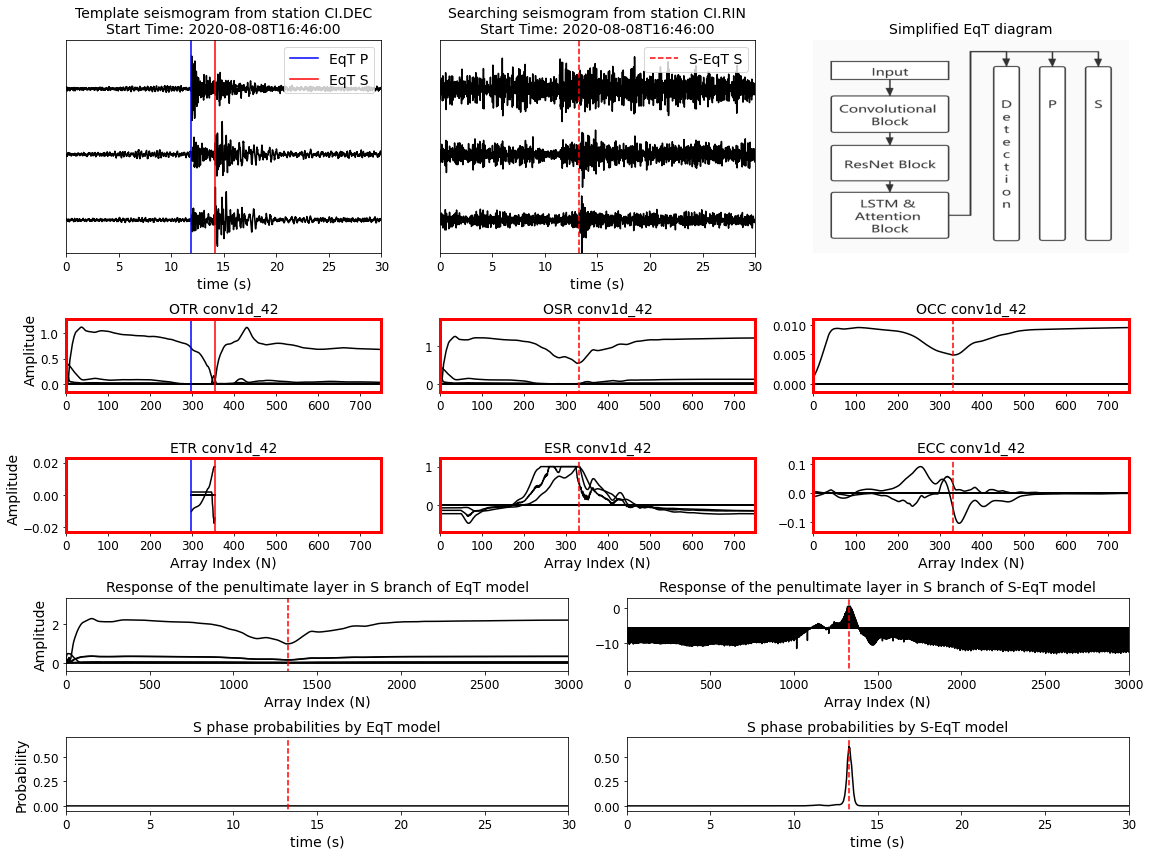

In [8]:
encoded_s  = encoded_s_plot
corr_res = enhanced_corr
res_search = search_eqt_pred
pred_res = search_seqt_pred
SEqT_S = np.argmax(search_seqt_pred[-1][0,:,0,0])

plot_t = np.arange(0,30.01,0.01)
plt.figure(figsize=(16,12))
ax1 = plt.subplot2grid((6,6),(0,4),colspan=2,rowspan=2)
plt.title('Simplified EqT diagram',fontsize=14)
img = mpimg.imread('/home/Public/SiameseEQTransformer/S-EqT_open_source/SiameseEarthquakeTransformer/Tutorial/01_explore_hidden_responses_in_the_pretrained_EqT/resources/EqT_diagram.jpg')
plt.imshow(img,aspect='auto')
plt.xticks([])
plt.yticks([])
ax1.axis('off')

ax_t1 = plt.subplot2grid((6,6),(0,0),rowspan=2,colspan=2)
for idx in range(3):
    plt.plot(plot_t,data_t[0:3001,idx]/np.max(np.abs(data_t[0:3001,idx]))+idx*2 + 2,color='k')
    if idx == '0':
        plt.text(28, idx*2 + 2 + 0.1, 'E')
    if idx == '1':
        plt.text(28, idx*2 + 2 + 0.1, 'N')
    if idx == '2':
        plt.text(28, idx*2 + 2 + 0.1, 'Z')

plt.plot([spt_t_eqt/100.0,spt_t_eqt/100.0],[1,8],color='b',label='EqT P')
plt.plot([sst_t_eqt/100.0,sst_t_eqt/100.0],[1,8],color='r',label='EqT S')
plt.title('Template seismogram from station CI.DEC\nStart Time: 2020-08-08T16:46:00',fontsize=14)
plt.ylim([1,7.5])
plt.legend(loc='upper right',prop= {'size':14})
plt.yticks([])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0,30])
plt.xlabel('time (s)',fontsize=14)

ax_t2 = plt.subplot2grid((6,6),(2,0),colspan=2)
rdx = 22
t_len = int(len(encoded_t_plot[rdx][0,:,0])/2.0)
for channel_dx in range(int(RSRN_channels[rdx])):
    plt.plot(encoded_t_plot[rdx][0,:t_len,channel_dx] + 0 * 2,color='k')
plt.xlim([0,t_len])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('OTR conv1d_42',fontsize=14)
plt.plot([spt_t_eqt/4.0,spt_t_eqt/4.0],[-50,50],color='b',label='EqT P')
plt.plot([sst_t_eqt/4.0,sst_t_eqt/4.0],[-50,50],color='r',label='EqT S')
t_min_plot = np.min(encoded_t_plot[rdx])
t_max_plot = np.max(encoded_t_plot[rdx])
t_gain = (t_max_plot - t_min_plot)*0.15
plt.ylim([t_min_plot - t_gain,t_max_plot + t_gain])
t_ax=plt.gca();t_ax.spines['right'].set_color('r');t_ax.spines['top'].set_color('r');t_ax.spines['bottom'].set_color('r');t_ax.spines['left'].set_color('r');t_ax.spines['right'].set_linewidth(3);t_ax.spines['top'].set_linewidth(3);t_ax.spines['bottom'].set_linewidth(3);t_ax.spines['left'].set_linewidth(3)
plt.text(-100,t_min_plot+t_gain*0.2,'Amplitude',fontsize=14,rotation=90)

ax_t3 = plt.subplot2grid((6,6),(3,0),colspan=2)
rdx = 22
t_len = int(len(encoded_t_plot[rdx][0,:,0])/2.0)
start_dx = int(spt_t_eqt*int(RSRN_lengths[rdx])/6000.0)
end_dx = start_dx + len(encoded_t_slice[rdx][0,:,0,0])
temp_x_plot = np.arange(start_dx,end_dx,1)
for channel_dx in range(int(RSRN_channels[rdx])):
    plt.plot(temp_x_plot, encoded_t_slice[rdx][0,:,0,channel_dx] + 0 * 2,color='k')
plt.xlim([0,t_len])
plt.title('ETR conv1d_42',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.plot([spt_t_eqt/4.0,spt_t_eqt/4.0],[-50,50],color='b',label='EqT P')
plt.plot([sst_t_eqt/4.0,sst_t_eqt/4.0],[-50,50],color='r',label='EqT S')
t_min_plot = np.min(encoded_t_slice[rdx])
t_max_plot = np.max(encoded_t_slice[rdx])
t_gain = (t_max_plot - t_min_plot)*0.15
plt.ylim([t_min_plot - t_gain,t_max_plot + t_gain])
t_ax=plt.gca();t_ax.spines['right'].set_color('r');t_ax.spines['top'].set_color('r');t_ax.spines['bottom'].set_color('r');t_ax.spines['left'].set_color('r');t_ax.spines['right'].set_linewidth(3);t_ax.spines['top'].set_linewidth(3);t_ax.spines['bottom'].set_linewidth(3);t_ax.spines['left'].set_linewidth(3)
plt.text(-140,t_min_plot+t_gain*0.2,'Amplitude',fontsize=14,rotation=90)
plt.xlabel('Array Index (N)',fontsize=14)

ax_t4 = plt.subplot2grid((6,6),(2,4),colspan=2)
rdx = 22
t_len = int(len(encoded_t_plot[rdx][0,:,0])/2.0)
for channel_dx in range(int(RSRN_channels[rdx])):
    plt.plot(ori_corr[rdx][0,:t_len,0,channel_dx]/57.0 + 0 * 2,color='k')
plt.xlim([0,t_len])
plt.title('OCC conv1d_42',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
t_min_plot = np.min(ori_corr[rdx])/57.0
t_max_plot = np.max(ori_corr[rdx])/57.0
t_gain = (t_max_plot - t_min_plot)*0.15
plt.ylim([t_min_plot - t_gain,t_max_plot + t_gain])
#plt.plot([SEqT_P/4.0,SEqT_P/4.0],[-50,50],color='b',linestyle='--',label='S-EqT P')
plt.plot([SEqT_S/4.0,SEqT_S/4.0],[-50,50],color='r',linestyle='--',label='S-EqT S')
t_ax=plt.gca();t_ax.spines['right'].set_color('r');t_ax.spines['top'].set_color('r');t_ax.spines['bottom'].set_color('r');t_ax.spines['left'].set_color('r');t_ax.spines['right'].set_linewidth(3);t_ax.spines['top'].set_linewidth(3);t_ax.spines['bottom'].set_linewidth(3);t_ax.spines['left'].set_linewidth(3)


ax_s1 = plt.subplot2grid((6,6),(0,2),rowspan=2,colspan=2)
for idx in range(3):
    plt.plot(plot_t,data_s[0:3001,idx]/np.max(np.abs(data_s[0:3001,idx]))+idx*2 + 2,color='k')
    if idx == '0':
        plt.text(28, idx*2 + 2 + 0.1, 'E')
    if idx == '1':
        plt.text(28, idx*2 + 2 + 0.1, 'N')
    if idx == '2':
        plt.text(28, idx*2 + 2 + 0.1, 'Z')

plt.yticks([])
#plt.plot([SEqT_P/100.0,SEqT_P/100.0],[1,8],color='b',linestyle='--',label='S-EqT P')
plt.plot([SEqT_S/100.0,SEqT_S/100.0],[1,8],color='r',linestyle='--',label='S-EqT S')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlim([0,30])
plt.ylim([1,7.5])
plt.legend(loc='upper right',prop= {'size':14})
#plt.text(0,7.5,'(c)',fontsize=20)
plt.title('Searching seismogram from station CI.RIN\nStart Time: 2020-08-08T16:46:00',fontsize=14)
plt.xlabel('time (s)',fontsize=14)


ax_s2 = plt.subplot2grid((6,6),(2,2),colspan=2)
rdx = 22
t_len = int(len(ori_response_list_for_vis[rdx*2+1][0,:,0,0])/2.0)
for channel_dx in range(int(RSRN_channels[rdx])):
    plt.plot(ori_response_list_for_vis[rdx*2+1][0,:t_len,0,channel_dx] + 0 * 2,color='k')    
plt.xlim([0,t_len])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('OSR conv1d_42',fontsize=14)
t_min_plot = np.min(ori_response_list_for_vis[rdx*2+1])
t_max_plot = np.max(ori_response_list_for_vis[rdx*2+1])
t_gain = (t_max_plot - t_min_plot)*0.15
plt.ylim([t_min_plot - t_gain,t_max_plot + t_gain])
#plt.plot([SEqT_P/4.0,SEqT_P/4.0],[-50,50],color='b',linestyle='--',label='S-EqT P')
plt.plot([SEqT_S/4.0,SEqT_S/4.0],[-50,50],color='r',linestyle='--',label='S-EqT S')
t_ax=plt.gca();t_ax.spines['right'].set_color('r');t_ax.spines['top'].set_color('r');t_ax.spines['bottom'].set_color('r');t_ax.spines['left'].set_color('r');t_ax.spines['right'].set_linewidth(3);t_ax.spines['top'].set_linewidth(3);t_ax.spines['bottom'].set_linewidth(3);t_ax.spines['left'].set_linewidth(3)

ax_s3 = plt.subplot2grid((6,6),(3,2),colspan=2)
rdx = 22
t_len = int(len(encoded_s[rdx][0,:,0,0])/2.0)
for channel_dx in range(int(RSRN_channels[rdx])):
    plt.plot(encoded_s[rdx][0,:t_len,0,channel_dx] + 0 * 2,color='k')
plt.xlim([0,t_len])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('ESR conv1d_42',fontsize=14)
t_min_plot = np.min(encoded_s[rdx])
t_max_plot = np.max(encoded_s[rdx])
t_gain = (t_max_plot - t_min_plot)*0.15
plt.ylim([t_min_plot - t_gain,t_max_plot + t_gain])
#plt.plot([SEqT_P/4.0,SEqT_P/4.0],[-50,50],color='b',linestyle='--',label='S-EqT P')
plt.plot([SEqT_S/4.0,SEqT_S/4.0],[-50,50],color='r',linestyle='--',label='S-EqT S')
t_ax=plt.gca();t_ax.spines['right'].set_color('r');t_ax.spines['top'].set_color('r');t_ax.spines['bottom'].set_color('r');t_ax.spines['left'].set_color('r');t_ax.spines['right'].set_linewidth(3);t_ax.spines['top'].set_linewidth(3);t_ax.spines['bottom'].set_linewidth(3);t_ax.spines['left'].set_linewidth(3)
plt.xlabel('Array Index (N)',fontsize=14)

ax_s4 = plt.subplot2grid((6,6),(3,4),colspan=2)
rdx = 22
t_len = int(len(encoded_s[rdx][0,:,0,0])/2.0)
for channel_dx in range(int(RSRN_channels[rdx])):
    plt.plot(corr_res[rdx][0,:,0,channel_dx] + 0 * 2,color='k')
plt.xlim([0,t_len])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('ECC conv1d_42',fontsize=14)
t_min_plot = np.min(corr_res[rdx])
t_max_plot = np.max(corr_res[rdx])
t_gain = (t_max_plot - t_min_plot)*0.15
plt.ylim([t_min_plot - t_gain,t_max_plot + t_gain])
#plt.plot([SEqT_P/4.0,SEqT_P/4.0],[-50,50],color='b',linestyle='--',label='S-EqT P')
plt.plot([SEqT_S/4.0,SEqT_S/4.0],[-50,50],color='r',linestyle='--',label='S-EqT S')
t_ax=plt.gca();t_ax.spines['right'].set_color('r');t_ax.spines['top'].set_color('r');t_ax.spines['bottom'].set_color('r');t_ax.spines['left'].set_color('r');t_ax.spines['right'].set_linewidth(3);t_ax.spines['top'].set_linewidth(3);t_ax.spines['bottom'].set_linewidth(3);t_ax.spines['left'].set_linewidth(3)
plt.xlabel('Array Index (N)',fontsize=14)

ax_eqt_final_resp = plt.subplot2grid((6,6),(4,0),colspan=3)
rdx = 24
t_len = int(len(ori_response_list_for_vis[rdx*2+1][0,:,0,0])/2.0)
for channel_dx in range(int(RSRN_channels[rdx])):
    plt.plot(ori_response_list_for_vis[rdx*2+1][0,:t_len,0,channel_dx] + 0 * 2,color='k')    
plt.xlim([0,t_len])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('OSR conv1d_42',fontsize=14)
t_min_plot = np.min(ori_response_list_for_vis[rdx*2+1])
t_max_plot = np.max(ori_response_list_for_vis[rdx*2+1])
t_gain = (t_max_plot - t_min_plot)*0.15
plt.ylim([t_min_plot - t_gain,t_max_plot + t_gain])
#plt.plot([SEqT_P,SEqT_P],[-50,50],color='b',linestyle='--',label='S-EqT P')
plt.plot([SEqT_S,SEqT_S],[-50,50],color='r',linestyle='--',label='S-EqT S')
#t_ax=plt.gca();t_ax.spines['right'].set_color('r');t_ax.spines['top'].set_color('r');t_ax.spines['bottom'].set_color('r');t_ax.spines['left'].set_color('r');t_ax.spines['right'].set_linewidth(3);t_ax.spines['top'].set_linewidth(3);t_ax.spines['bottom'].set_linewidth(3);t_ax.spines['left'].set_linewidth(3)
plt.xlabel('Array Index (N)',fontsize=14)
plt.title('Response of the penultimate layer in S branch of EqT model',fontsize=14)
plt.ylabel('Amplitude',fontsize=14)

ax_seqt_final_resp = plt.subplot2grid((6,6),(4,3),colspan=3)
for idx in range(7):
    plt.plot(search_SEqT_penultimate_response[0,:,0,idx],color='k')
t_min_plot = np.min(search_SEqT_penultimate_response)
t_max_plot = np.max(search_SEqT_penultimate_response)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
t_gain = (t_max_plot - t_min_plot)*0.15
plt.ylim([t_min_plot - t_gain,t_max_plot + t_gain])
#plt.plot([SEqT_P,SEqT_P],[-40,40],color='b',linestyle='--',label='S-EqT P')
plt.plot([SEqT_S,SEqT_S],[-40,40],color='r',linestyle='--',label='S-EqT S')
plt.xlim([0,t_len])
#plt.ylabel('Amplitude',fontsize=14)
plt.xlabel('Array Index (N)',fontsize=14)
plt.title('Response of the penultimate layer in S branch of S-EqT model',fontsize=14)

ax_eqt_final = plt.subplot2grid((6,6),(5,0),colspan=3)
plt.plot(plot_t,res_search[2][0,0:3001,0],color='k')
plt.ylim([-0.05,0.7])
plt.xlim([0,30])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.plot([SEqT_P/100.0,SEqT_P/100.0],[-1,1],color='b',linestyle='--',label='S-EqT P')
plt.plot([SEqT_S/100.0,SEqT_S/100.0],[-1,1],color='r',linestyle='--',label='S-EqT S')
plt.xlabel('time (s)',fontsize=14)
plt.ylabel('Probability',fontsize=14)
plt.title('S phase probabilities by EqT model',fontsize=14)

ax_seqt_final = plt.subplot2grid((6,6),(5,3),colspan=3)
plt.plot(plot_t,pred_res[-1][0,0:3001,0,0],color='k')
plt.xlim([0,30])
plt.ylim([-0.05,0.7])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#plt.plot([SEqT_P/100.0,SEqT_P/100.0],[-1,1],color='b',linestyle='--',label='S-EqT P')
plt.plot([SEqT_S/100.0,SEqT_S/100.0],[-1,1],color='r',linestyle='--',label='S-EqT S')
#plt.xlabel('time (s)',fontsize=14)
plt.title('S phase probabilities by S-EqT model',fontsize=14)
plt.xlabel('time (s)',fontsize=14)
plt.tight_layout()
plt.show()
plt.close()